In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import tifffile
import torchvision.transforms as transforms
import os

class PairedMedicalSliceDataset(Dataset):
    def __init__(self, us_file_paths, mri_file_paths, num_slices=10, transform=None):
        assert len(us_file_paths) == len(mri_file_paths), "US and MRI file length not match!"

        self.us_file_paths = us_file_paths
        self.mri_file_paths = mri_file_paths
        self.num_slices = num_slices
        self.transform = transform
        self.all_slices = []

        for us_path, mri_path in zip(us_file_paths, mri_file_paths):
            with tifffile.TiffFile(us_path) as us_tif, tifffile.TiffFile(mri_path) as mri_tif:
                us_volume = us_tif.asarray()
                mri_volume = mri_tif.asarray()

                num_total_slices = us_volume.shape[2]
                assert num_total_slices == mri_volume.shape[2], f"{us_path} and {mri_path} slice length not match！"

                mid_start = (num_total_slices // 2) - (num_slices // 2)
                mid_slices = list(range(mid_start, mid_start + num_slices))

                for slice_idx in mid_slices:
                    if 0 <= slice_idx < num_total_slices:
                        self.all_slices.append((us_path, mri_path, slice_idx))

    def __len__(self):
        return len(self.all_slices)

    def __getitem__(self, idx):
        us_path, mri_path, slice_idx = self.all_slices[idx]

        with tifffile.TiffFile(us_path) as us_tif, tifffile.TiffFile(mri_path) as mri_tif:
            us_volume = us_tif.asarray()
            mri_volume = mri_tif.asarray()

            us_slice = us_volume[:, :, slice_idx]
            mri_slice = mri_volume[:, :, slice_idx]

        us_tensor = torch.tensor(us_slice, dtype=torch.float32).unsqueeze(0)
        mri_tensor = torch.tensor(mri_slice, dtype=torch.float32).unsqueeze(0)

        us_tensor = us_tensor / us_tensor.max()
        mri_tensor = mri_tensor / mri_tensor.max()

        if self.transform:
            us_tensor, mri_tensor = self.transform(us_tensor, mri_tensor)

        return us_tensor, mri_tensor


class PairedTransform:
    def __init__(self, base_transform):
        self.base_transform = base_transform

    def __call__(self, us, mri):
        state = torch.get_rng_state()
        us = self.base_transform(us)
        torch.set_rng_state(state)
        mri = self.base_transform(mri)
        return us, mri

base_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
])

paired_transform = PairedTransform(base_transform)

us_files = [
    "/content/E0_Patient_01_US.tif",
    "/content/E0_Patient_07_US.tif",
    "/content/E0_Patient_12_US.tif",
    "/content/E0_Patient_17_US.tif",
    "/content/E0_Patient_01_US_new.tif",
    "/content/E0_Patient_07_US_new.tif",
    "/content/E0_Patient_14_US_new.tif",
    "/content/E0_Patient_16_US_new.tif",
]
mri_files = [
    "/content/E0_Patient_01_MR.tif",
    "/content/E0_Patient_07_MR.tif",
    "/content/E0_Patient_12_MR.tif",
    "/content/E0_Patient_17_MR.tif",
    "/content/E0_Patient_01_MR_new.tif",
    "/content/E0_Patient_07_MR_new.tif",
    "/content/E0_Patient_14_MR_new.tif",
    "/content/E0_Patient_16_MR_new.tif",
]

us_vad = [
    "/content/E0_Patient_17_US.tif",
]
mri_vad = [
    "/content/E0_Patient_17_MR.tif",
]

us_visual = [
    "/content/E0_Patient_18_US.tif",
]
mri_visual = [
    "/content/E0_Patient_18_MR.tif",
]



batch_size = 1

paired_dataset = PairedMedicalSliceDataset(us_files, mri_files, num_slices=10, transform=paired_transform)
paired_loader = DataLoader(paired_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
vad_dataset = PairedMedicalSliceDataset(us_vad, mri_vad, num_slices=10, transform=None)
vad_loader = DataLoader(vad_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
visual_dataset = PairedMedicalSliceDataset(us_visual, mri_visual, num_slices=1, transform=None)
visual_loader = DataLoader(visual_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


In [ ]:
!pip install pytorch_wavelets
!pip install PyWavelets

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_wavelets import DWTForward, DWTInverse


class WaveletTransform(nn.Module):
    def __init__(self, wave='db2'):
        super().__init__()
        self.dwt = DWTForward(J=1, wave=wave)   
        self.idwt = DWTInverse(wave=wave)

    def forward_dwt(self, x):
        cA, cD = self.dwt(x)
        cD0 = cD[0]
        return (cA, cD0)

    def inverse_dwt(self, cA, cD0):
        cD = [cD0]
        x_rec = self.idwt((cA, cD))
        return x_rec

def soft_threshold(x, lam):
    return torch.sign(x) * F.relu(torch.abs(x) - lam)

def grad_data_fidelity(xA, xD, y1, y2, wavelet_op):
    x_im = wavelet_op.inverse_dwt(xA, xD)
    grad_im = (x_im - y1) + (x_im - y2)
    gA, gD = wavelet_op.forward_dwt(grad_im)
    return gA, gD

def grad_coupling(xA, xD, vA, vD, gamma):
    return ( gamma*(vA - xA), gamma*(vD - xD) )

class GMC_CNNIteration(nn.Module):
    def __init__(self, lam=0.02, gamma=0.8, mu=0.5,
                 wavelet_op=None, hidden_ch=16, in_ch=1):
        super().__init__()
        self.lam = nn.Parameter(torch.tensor(lam))
        self.gamma = nn.Parameter(torch.tensor(gamma))
        self.mu = nn.Parameter(torch.tensor(mu))
        self.wavelet_op = wavelet_op  

    def forward(self, xA, xD, vA, vD, y1, y2):
        gA_data, gD_data = grad_data_fidelity(xA, xD, y1, y2, self.wavelet_op)
        gA_coup_x, gD_coup_x = grad_coupling(xA, xD, vA, vD, self.gamma)

        wA = xA - self.mu*(gA_data + gA_coup_x)
        wD = xD - self.mu*(gD_data + gD_coup_x)

        gA_coup_v, gD_coup_v = grad_coupling(xA, xD, vA, vD, self.gamma)
        uA = vA - self.mu*gA_coup_v
        uD = vD - self.mu*gD_coup_v

        xA_new = soft_threshold(wA, self.mu*self.lam)
        xD_new = soft_threshold(wD, self.mu*self.lam)
        vA_new = soft_threshold(uA, self.mu*self.lam)
        vD_new = soft_threshold(uD, self.mu*self.lam)

        x_im = self.wavelet_op.inverse_dwt(xA_new, xD_new)
        return xA_new, xD_new, vA_new, vD_new

class GMC_CNN_FusionNet(nn.Module):
    def __init__(self, K=5, lam=0.02, gamma=0.8, mu=0.5, wave='db2',
                 hidden_ch=16, in_ch=1):
        super().__init__()
        self.wavelet_op = WaveletTransform(wave=wave)
        self.iters = nn.ModuleList([
            GMC_CNNIteration(lam=lam, gamma=gamma, mu=mu,
                             wavelet_op=self.wavelet_op,
                             hidden_ch=hidden_ch, in_ch=in_ch)
            for _ in range(K)
        ])

    def forward(self, y1, y2):
        with torch.no_grad():
            x0_im = 0.5*(y1 + y2)
            x0A, x0D = self.wavelet_op.forward_dwt(x0_im)

        xA, xD = x0A, x0D
        vA, vD = x0A, x0D

        for block in self.iters:
            xA, xD, vA, vD = block(xA, xD, vA, vD, y1, y2)

        return xA, xD, vA, vD


def wavelet_fusion_loss(xA, xD, y1, y2, wavelet_op, eps=1e-6):
    fused_im = wavelet_op.inverse_dwt(xA, xD)
    fA, fD = wavelet_op.forward_dwt(fused_im)
    y1A, y1D = wavelet_op.forward_dwt(y1)
    y2A, y2D = wavelet_op.forward_dwt(y2)

    def softmax_subband(sb1, sb2):
        return (torch.abs(sb1)/(torch.abs(sb1)+torch.abs(sb2)+eps))*sb1 + (torch.abs(sb2)/(torch.abs(sb1)+torch.abs(sb2)+eps))*sb2

    A_star = softmax_subband(y1A, y2A)
    lossA = (fA - A_star).pow(2).mean()

    fH = fD[:, :, 0]
    fV = fD[:, :, 1]
    fDg= fD[:, :, 2]
    y1H= y1D[:, :, 0]
    y1V= y1D[:, :, 1]
    y1Dg= y1D[:, :, 2]
    y2H= y2D[:, :, 0]
    y2V= y2D[:, :, 1]
    y2Dg= y2D[:, :, 2]

    H_star = softmax_subband(y1H, y2H)
    V_star = softmax_subband(y1V, y2V)
    Dg_star= softmax_subband(y1Dg, y2Dg)

    lossH = (fH - H_star).pow(2).mean()
    lossV = (fV - V_star).pow(2).mean()
    lossDg= (fDg- Dg_star).pow(2).mean()

    return lossA + lossH + lossV + lossDg




In [ ]:
!pip install pytorch-msssim

In [ ]:
from pytorch_msssim import ssim
import torch
import torch.nn.functional as F

def combined_fusion_loss(xA, xD, y1, y2, wavelet_op, ssim_weight=0.1, mse_weight=1.0, eps=1e-6):
    wf_loss = wavelet_fusion_loss(xA, xD, y1, y2, wavelet_op, eps)

    fused_im = wavelet_op.inverse_dwt(xA, xD)
    avg_im = 0.5 * (y1 + y2)

    ssim_loss = 1 - ssim(fused_im, avg_im, data_range=avg_im.max() - avg_im.min(), size_average=True)

    mse_loss = F.mse_loss(fused_im, avg_im)

    return wf_loss + ssim_weight * ssim_loss + mse_weight * mse_loss


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


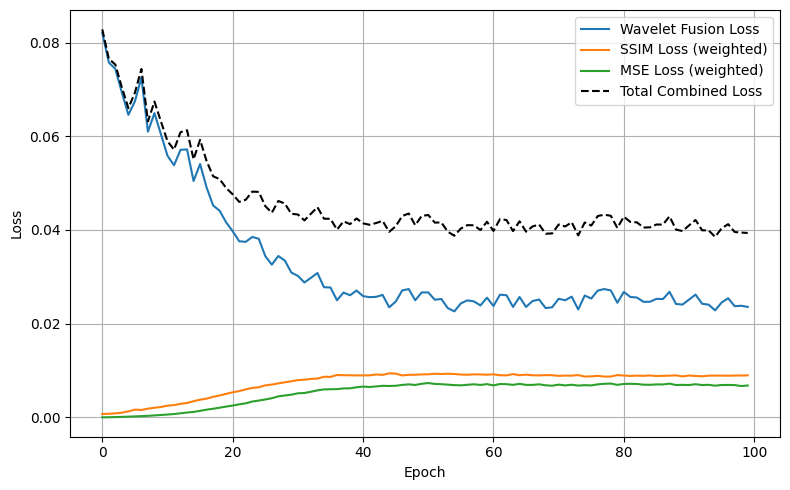

In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from pytorch_msssim import ssim

learning_rate = 1e-4
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ssim_weight = 0.1
mse_weight  = 1.0

model = GMC_CNN_FusionNet(K=5, lam=0.02, gamma=0.8, mu=0.5, wave='db2', hidden_ch=16, in_ch=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, verbose=True)

# for epoch in range(num_epochs):
#     total_loss = 0
#     model.train()
#     for us_batch, mri_batch in paired_loader:
#         us, mri = us_batch.to(device), mri_batch.to(device)

#         optimizer.zero_grad()
#         xA, xD, vA, vD = model(mri, us)
#         loss = combined_fusion_loss(xA, xD, mri, us, wavelet_op=model.wavelet_op)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()

#     scheduler.step(total_loss / len(paired_loader))

#     if epoch % 10 == 0:
#         print(f"Epoch {epoch}/{num_epochs}, Loss: {total_loss / len(paired_loader)}, LR: {optimizer.param_groups[0]['lr']}")


# loss_history = []

# for epoch in range(num_epochs):
#     total_loss = 0
#     model.train()
#     for us_batch, mri_batch in paired_loader:
#         us, mri = us_batch.to(device), mri_batch.to(device)

#         optimizer.zero_grad()
#         xA, xD, vA, vD = model(mri, us)
#         loss = combined_fusion_loss(xA, xD, mri, us, wavelet_op=model.wavelet_op)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()

#     avg_loss = total_loss / len(paired_loader)
#     loss_history.append(avg_loss)
#     scheduler.step(avg_loss)

#     if epoch % 10 == 0:
#         print(f"Epoch {epoch}/{num_epochs}, Loss: {avg_loss:.4f}, LR: {optimizer.param_groups[0]['lr']}")


# import matplotlib.pyplot as plt

# plt.figure(figsize=(8, 5))
# plt.plot(range(num_epochs), loss_history, marker='o')
# plt.xlabel('Epoch')
# plt.ylabel('Average Training Loss')
# # plt.title('Training Loss Curve')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# train_loss_history = []
# val_loss_history   = []

# for epoch in range(num_epochs):
#     model.train()
#     total_train = 0
#     for us_batch, mri_batch in paired_loader:
#         us, mri = us_batch.to(device), mri_batch.to(device)
#         optimizer.zero_grad()
#         xA, xD, vA, vD = model(mri, us)
#         loss = combined_fusion_loss(xA, xD, mri, us, wavelet_op=model.wavelet_op)
#         loss.backward()
#         optimizer.step()
#         total_train += loss.item()

#     avg_train = total_train / len(paired_loader)
#     train_loss_history.append(avg_train)

#     model.eval()
#     total_val = 0
#     with torch.no_grad():
#         for us_batch, mri_batch in vad_loader:
#             us, mri = us_batch.to(device), mri_batch.to(device)
#             xA, xD, vA, vD = model(mri, us)
#             loss = combined_fusion_loss(xA, xD, mri, us, wavelet_op=model.wavelet_op)
#             total_val += loss.item()

#     avg_val = total_val / len(vad_loader)
#     val_loss_history.append(avg_val)

#     scheduler.step(avg_val)

#     if epoch % 10 == 0:
#         print(f"Epoch {epoch}/{num_epochs}  "
#               f"Train Loss: {avg_train:.4f}  "
#               f"Val Loss: {avg_val:.4f}  "
#               f"LR: {optimizer.param_groups[0]['lr']}")

# import matplotlib.pyplot as plt

# plt.figure(figsize=(8,5))
# plt.plot(train_loss_history, label='Train')
# plt.plot(val_loss_history,   label='Validation')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# # plt.title('Train vs. Validation Loss')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

wavelet_history = []
ssim_history    = []
mse_history     = []
combined_history= []

for epoch in range(num_epochs):
    model.train()
    total_wf = total_s  = total_m  = total_c  = 0

    for us_batch, mri_batch in paired_loader:
        us, mri = us_batch.to(device), mri_batch.to(device)
        optimizer.zero_grad()

        xA, xD, vA, vD = model(mri, us)
        wf_loss = wavelet_fusion_loss(xA, xD, mri, us, wavelet_op=model.wavelet_op)

        fused_im = model.wavelet_op.inverse_dwt(xA, xD)
        avg_im   = 0.5 * (mri + us)
        ssim_val = ssim(fused_im, avg_im,
                        data_range=avg_im.max()-avg_im.min(),
                        size_average=True)
        ssim_loss = 1 - ssim_val

        mse_loss  = F.mse_loss(fused_im, avg_im)

        sw, ss, sm = 1.0, ssim_weight, mse_weight

        combined = wf_loss*sw + ssim_weight*ssim_loss + mse_weight*mse_loss
        combined.backward()
        optimizer.step()

        total_wf += wf_loss.item()
        total_s  += (ssim_weight*ssim_loss).item()
        total_m  += (mse_weight*mse_loss).item()
        total_c  += combined.item()

    wavelet_history.append(total_wf / len(paired_loader))
    ssim_history.append(   total_s  / len(paired_loader))
    mse_history.append(    total_m  / len(paired_loader))
    combined_history.append(total_c  / len(paired_loader))

    scheduler.step(total_c / len(paired_loader))

import matplotlib.pyplot as plt

epochs = range(num_epochs)
plt.figure(figsize=(8,5))
plt.plot(epochs, wavelet_history, label='Wavelet Fusion Loss')
plt.plot(epochs, ssim_history,    label='SSIM Loss (weighted)')
plt.plot(epochs, mse_history,     label='MSE Loss (weighted)')
plt.plot(epochs, combined_history,label='Total Combined Loss', linestyle='--', color='k')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()





In [ ]:
import numpy as np
import cv2

def gradient_magnitude_orientation(img):
    gx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    G = np.sqrt(gx**2 + gy**2)
    phi = np.arctan2(gy, gx) 
    return G, phi

def xydeas_petrovic(fused, img1, img2, eps=1e-12):
    fused = fused.astype(np.float64)
    img1  = img1.astype(np.float64)
    img2  = img2.astype(np.float64)

    Gf, Phif = gradient_magnitude_orientation(fused)
    G1, Phi1 = gradient_magnitude_orientation(img1)
    G2, Phi2 = gradient_magnitude_orientation(img2)

    Gmax12 = np.maximum(G1, G2)

    Sg1 = (Gf + eps) / (G1 + eps)  
    Sg2 = (Gf + eps) / (G2 + eps)  

    So1 = 1.0 - np.abs(Phif - Phi1) / (np.pi)  
    So2 = 1.0 - np.abs(Phif - Phi2) / (np.pi)

    W1 = G1 / (G1 + G2 + eps)
    W2 = G2 / (G1 + G2 + eps)

    Q1 = Sg1 * So1
    Q2 = Sg2 * So2

    Qfuse = W1 * Q1 + W2 * Q2
    E_score = np.mean(Qfuse)
    return E_score


In [ ]:
def local_stats(arr, window_size=3):
    kernel = np.ones((window_size, window_size), dtype=np.float64) / (window_size**2)
    mean = cv2.filter2D(arr, -1, kernel)
    mean_sq = cv2.filter2D(arr*arr, -1, kernel)
    var = mean_sq - mean**2
    return mean, var

def Q0_metric(fused, img1, img2, window_size=3):
    fused  = fused.astype(np.float64)
    img1   = img1.astype(np.float64)
    img2   = img2.astype(np.float64)

    f_mean, f_var = local_stats(fused, window_size)
    i1_mean, i1_var = local_stats(img1, window_size)
    i2_mean, i2_var = local_stats(img2, window_size)

    w1 = i1_var / (i1_var + i2_var + 1e-12)
    w2 = i2_var / (i1_var + i2_var + 1e-12)

    part1 = w1 * ((2*(f_mean*i1_mean)+1e-12)/(f_mean**2 + i1_mean**2 +1e-12)) \
            + w2 * ((2*(f_mean*i2_mean)+1e-12)/(f_mean**2 + i2_mean**2 +1e-12))

    part2 = w1 * ((2*np.sqrt(f_var*i1_var)+1e-12)/(f_var + i1_var +1e-12)) \
            + w2 * ((2*np.sqrt(f_var*i2_var)+1e-12)/(f_var + i2_var +1e-12))

    Q0_map = part1 * part2

    Q0_score = np.mean(Q0_map)
    return Q0_score


In [ ]:
def piella_Q_metric(fused, img1, img2, window_size=3):
    fused = fused.astype(np.float64)
    img1  = img1.astype(np.float64)
    img2  = img2.astype(np.float64)

    def local_variance(x):
        m, v = local_stats(x, window_size)
        return v
    var1 = local_variance(img1)
    var2 = local_variance(img2)

    W1 = var1 / (var1 + var2 + 1e-12)
    W2 = var2 / (var1 + var2 + 1e-12)

    f_mean, f_var = local_stats(fused, window_size)
    i1_mean, i1_var = local_stats(img1, window_size)
    i2_mean, i2_var = local_stats(img2, window_size)

    corr_f1 = (cv2.filter2D(fused * img1, -1, np.ones((window_size,window_size))/(window_size**2))
               - f_mean*i1_mean) / (np.sqrt(f_var*i1_var)+1e-12)
    corr_f2 = (cv2.filter2D(fused * img2, -1, np.ones((window_size,window_size))/(window_size**2))
               - f_mean*i2_mean) / (np.sqrt(f_var*i2_var)+1e-12)

    Q_map = W1 * corr_f1 + W2 * corr_f2

    Q_score = np.mean(Q_map)
    return Q_score


Petrovic E:  0.7784
Wang Q0:    0.0534
Piella Q:    0.8438


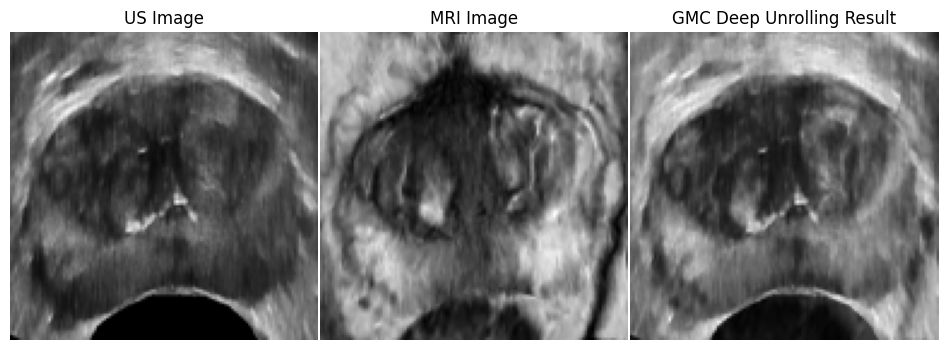

In [ ]:
import torch
import matplotlib.pyplot as plt

def visualize_fusion(model, paired_loader, device):
    model.eval()
    us_batch, mri_batch = next(iter(paired_loader))
    us_batch, mri_batch = us_batch.to(device), mri_batch.to(device)

    with torch.no_grad():
        xA, xD, vA, vD = model(us_batch, mri_batch)
        fused_tensor = model.wavelet_op.inverse_dwt(xA, xD)  

    fused_image = fused_tensor[0, 0].cpu().numpy()
    us_image = us_batch[0, 0].cpu().numpy()
    mri_image = mri_batch[0, 0].cpu().numpy()

    E_val   = xydeas_petrovic(fused_image, mri_image, us_image)
    Q0_val  = Q0_metric(fused_image, mri_image, us_image)
    Q_val   = piella_Q_metric(fused_image, mri_image, us_image)

    print(f"Petrovic E:  {E_val:.4f}")
    print(f"Wang Q0:    {Q0_val:.4f}")
    print(f"Piella Q:    {Q_val:.4f}")

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    plt.subplots_adjust(wspace=0, hspace=0)  

    ax[0].imshow(us_image, cmap='gray')
    ax[0].set_title("US Image")
    ax[0].axis("off")
    ax[1].imshow(mri_image, cmap='gray')
    ax[1].set_title("MRI Image")
    ax[1].axis("off")
    ax[2].imshow(fused_image, cmap='gray')
    ax[2].set_title("GMC Deep Unrolling Result")
    ax[2].axis("off")
    plt.show()

visualize_fusion(model, visual_loader, device)


Petrovic E:  0.7784
Wang Q0:    0.0534
Piella Q:    0.8438


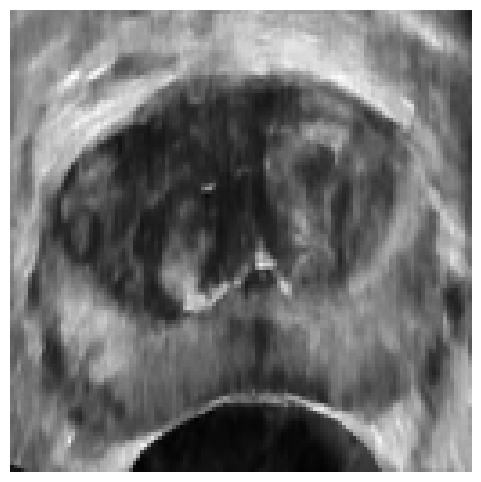

In [ ]:
def visualize_fusion(model, paired_loader, device):
    model.eval()
    us_batch, mri_batch = next(iter(paired_loader))
    us_batch, mri_batch = us_batch.to(device), mri_batch.to(device)

    with torch.no_grad():
        xA, xD, vA, vD = model(us_batch, mri_batch)
        fused_tensor = model.wavelet_op.inverse_dwt(xA, xD) 

    fused_image = fused_tensor[0, 0].cpu().numpy()
    us_image = us_batch[0, 0].cpu().numpy()
    mri_image = mri_batch[0, 0].cpu().numpy()

    E_val   = xydeas_petrovic(fused_image, mri_image, us_image)
    Q0_val  = Q0_metric(fused_image, mri_image, us_image)
    Q_val   = piella_Q_metric(fused_image, mri_image, us_image)

    print(f"Petrovic E:  {E_val:.4f}")
    print(f"Wang Q0:    {Q0_val:.4f}")
    print(f"Piella Q:    {Q_val:.4f}")


    plt.figure(figsize=(6, 6))
    plt.imshow(fused_image, cmap='gray')
    plt.axis("off")
    plt.show()
visualize_fusion(model, visual_loader, device)


Petrovic E:  0.7784
Wang Q0:    0.0534
Piella Q:    0.8438


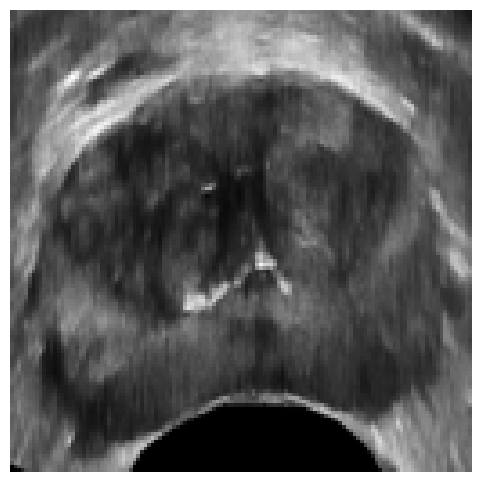

In [ ]:
def visualize_fusion(model, paired_loader, device):
    model.eval()
    us_batch, mri_batch = next(iter(paired_loader))
    us_batch, mri_batch = us_batch.to(device), mri_batch.to(device)

    with torch.no_grad():
        xA, xD, vA, vD = model(us_batch, mri_batch)
        fused_tensor = model.wavelet_op.inverse_dwt(xA, xD)

    fused_image = fused_tensor[0, 0].cpu().numpy()
    us_image = us_batch[0, 0].cpu().numpy()
    mri_image = mri_batch[0, 0].cpu().numpy()

    E_val   = xydeas_petrovic(fused_image, mri_image, us_image)
    Q0_val  = Q0_metric(fused_image, mri_image, us_image)
    Q_val   = piella_Q_metric(fused_image, mri_image, us_image)

    print(f"Petrovic E:  {E_val:.4f}")
    print(f"Wang Q0:    {Q0_val:.4f}")
    print(f"Piella Q:    {Q_val:.4f}")


    plt.figure(figsize=(6, 6))
    plt.imshow(us_image, cmap='gray')
    plt.axis("off")
    plt.show()
visualize_fusion(model, visual_loader, device)

Petrovic E:  0.7784
Wang Q0:    0.0534
Piella Q:    0.8438


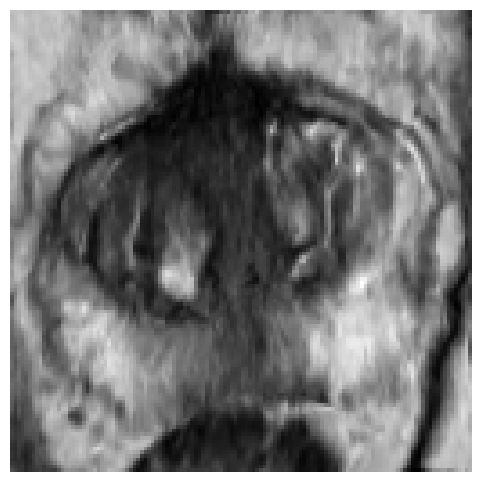

In [ ]:
def visualize_fusion(model, paired_loader, device):
    model.eval()
    us_batch, mri_batch = next(iter(paired_loader))
    us_batch, mri_batch = us_batch.to(device), mri_batch.to(device)

    with torch.no_grad():
        xA, xD, vA, vD = model(us_batch, mri_batch)
        fused_tensor = model.wavelet_op.inverse_dwt(xA, xD)  

    fused_image = fused_tensor[0, 0].cpu().numpy()
    us_image = us_batch[0, 0].cpu().numpy()
    mri_image = mri_batch[0, 0].cpu().numpy()

    E_val   = xydeas_petrovic(fused_image, mri_image, us_image)
    Q0_val  = Q0_metric(fused_image, mri_image, us_image)
    Q_val   = piella_Q_metric(fused_image, mri_image, us_image)

    print(f"Petrovic E:  {E_val:.4f}")
    print(f"Wang Q0:    {Q0_val:.4f}")
    print(f"Piella Q:    {Q_val:.4f}")


    plt.figure(figsize=(6, 6))
    plt.imshow(mri_image, cmap='gray')
    plt.axis("off")
    plt.show()
visualize_fusion(model, visual_loader, device)

In [ ]:
!pip install pytorch_wavelets
!pip install PyWavelets

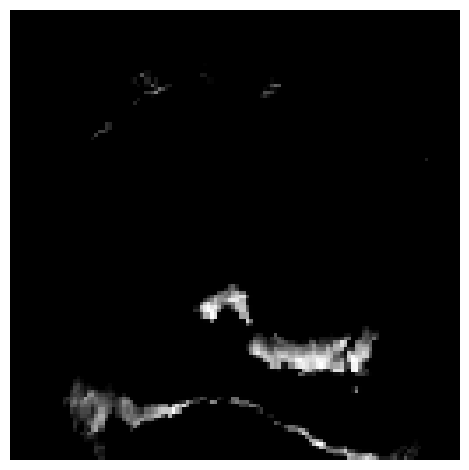

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from PIL import Image, ImageSequence
import numpy as np
import matplotlib.pyplot as plt


paired_dataset = PairedMedicalSliceDataset(us_files, mri_files, num_slices=1, transform=paired_transform)
paired_loader = DataLoader(paired_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
us_batch, mri_batch = next(iter(paired_loader))

def visualize_wavelet_coeffs(image, wavelet='haar'):
    cA, (cH, cV, cD) = pywt.dwt2(image, wavelet)


    plt.imshow(img, cmap='gray')
    # # axes[0, 0].set_title('Original US Image')
    plt.axis('off')

    # axes[0, 0].imshow(cA, cmap='gray')
    # axes[0, 0].set_title('Approximation Coefficients (LL₁)')
    # axes[0, 0].axis('off')

    # axes[0, 1].imshow(cH, cmap='gray')
    # axes[0, 1].set_title('Horizontal Detail (LH₁)')
    # axes[0, 1].axis('off')

    # axes[1, 0].imshow(cV, cmap='gray')
    # axes[1, 0].set_title('Vertical Detail (HL₁)')
    # axes[1, 0].axis('off')

    # axes[1, 1].imshow(cD, cmap='gray')
    # axes[1, 1].set_title('Diagonal Detail (HH₁)')
    # axes[1, 1].axis('off')

    # axes[1, 2].axis('off')

    plt.tight_layout()
    plt.show()

img = us_batch.squeeze()
visualize_wavelet_coeffs(img, wavelet='haar')
